In [49]:
from flash_ansr import FlashANSRDataset, get_path
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import defaultdict

In [50]:
# MODEL = 'v22.4-60M'
MODEL = 'v23.0-3M'

In [51]:
dataset = FlashANSRDataset.from_config(get_path('configs', MODEL, 'dataset_train.yaml'))

Compiling Skeletons: 100%|██████████| 107/107 [00:00<00:00, 18639.80it/s]


In [52]:
N_SAMPLES = 2**17
# N_SAMPLES = 2**10
print(f'{N_SAMPLES:,}')

131,072


In [53]:
# data['skeleton'] = [[str(token) for token in d[0]] for d in data['skeleton']]
# data['expression'] = [[str(token) for token in d[0]] for d in data['expression']]
# data['constants'] = [[float(constant) for constant in d[0]] for d in data['constants']]
# data['n_support'] = np.array([(~(s[0] == 0).all(axis=1)).sum() for s in data['x_tensors']])
# data['all_x'] = np.array([x.item() for x_tensor in tqdm(data['x_tensors']) for x in x_tensor.flatten()])
# data['all_x'] = data['all_x'][data['all_x'] != 0]
# data['all_y'] = np.array([y.item() for y_tensor in tqdm(data['y_tensors']) for y in y_tensor.flatten()])
# data['all_constants'] = np.array([c for constants in tqdm(data['constants']) for c in constants])
# data['n_constants'] = np.array([len(constants) for constants in data['constants']])
# data['n_variables'] = np.array([len([token for token in s if token.startswith('x')]) for s in data['skeleton']])
# data['n_unique_variables'] = np.array([len(set([token for token in s if token.startswith('x')])) for s in data['skeleton']])
# data['lengths'] = np.array([len(s) for s in data['skeleton']])

data = defaultdict(list)

for d in dataset.iterate(size=N_SAMPLES, verbose=True, persistent=True, n_per_equation=1, batch_size=1, preprocess=True, preprocess_in_worker=True):
    data['skeleton'].append([str(token) for token in d['skeleton'][0]])
    data['expression'].append([str(token) for token in d['expression'][0]])
    data['constants'].append([float(constant) for constant in d['constants'][0]])
    data['n_support'].append((~(d['x_tensors'][0] == 0).all(axis=1)).sum().item())
    data['x_tensors'].append(d['x_tensors'][0])
    data['y_tensors'].append(d['y_tensors'][0])
    data['all_x'].extend([x.item() for x_tensor in d['x_tensors'] for x in x_tensor.flatten() if x.item() != 0])
    data['all_y'].extend([y.item() for y_tensor in d['y_tensors'] for y in y_tensor.flatten()])
    data['all_constants'].extend([c for c in d['constants'][0]])
    data['n_constants'].append(len(d['constants'][0]))
    data['n_variables'].append(len([token for token in d['skeleton'][0] if token.startswith('x')]))
    data['n_unique_variables'].append(len(set([token for token in d['skeleton'][0] if token.startswith('x')])))
    data['lengths'].append(len(d['skeleton'][0]))

/tmp/ipykernel_18656/3393449370.py:16: RuntimeWarning: worker preprocessing requested but no preprocessor configured; falling back to main process.
  for d in dataset.iterate(size=N_SAMPLES, verbose=True, persistent=True, n_per_equation=1, batch_size=1, preprocess=True, preprocess_in_worker=True):
Generating Batches: 100%|██████████| 131072/131072 [56:41<00:00, 38.53it/s]


In [54]:
data['n_support'] = np.array(data['n_support']).flatten()
data['all_x'] = np.array(data['all_x']).flatten()
data['all_y'] = np.array(data['all_y']).flatten()
data['all_constants'] = np.array(data['all_constants']).flatten()
data['n_constants'] = np.array(data['n_constants']).flatten()
data['n_variables'] = np.array(data['n_variables']).flatten()
data['n_unique_variables'] = np.array(data['n_unique_variables']).flatten()
data['lengths'] = np.array(data['lengths']).flatten()

In [55]:
def format_int(x):
    if x < 1_000:
        return int(x)
    elif x < 1_000_000:
        return f'{int(x // 1_000)}k' if x % 1_000 == 0 else f'{x / 1_000:.1f}k'
    else:
        return f'{int(x // 1_000_000)}M' if x % 1_000_000 == 0 else f'{x / 1_000_000:.1f}M'

  0%|          | 0/8 [00:00<?, ?it/s]

131,072 samples for n_support
80,830 samples for all_constants
371,454,668 samples for all_x


 38%|███▊      | 3/8 [00:20<00:34,  6.97s/it]

134,217,728 samples for all_y


 88%|████████▊ | 7/8 [00:25<00:03,  3.66s/it]


131,072 samples for lengths
131,072 samples for n_constants
131,072 samples for n_variables
131,072 samples for n_unique_variables


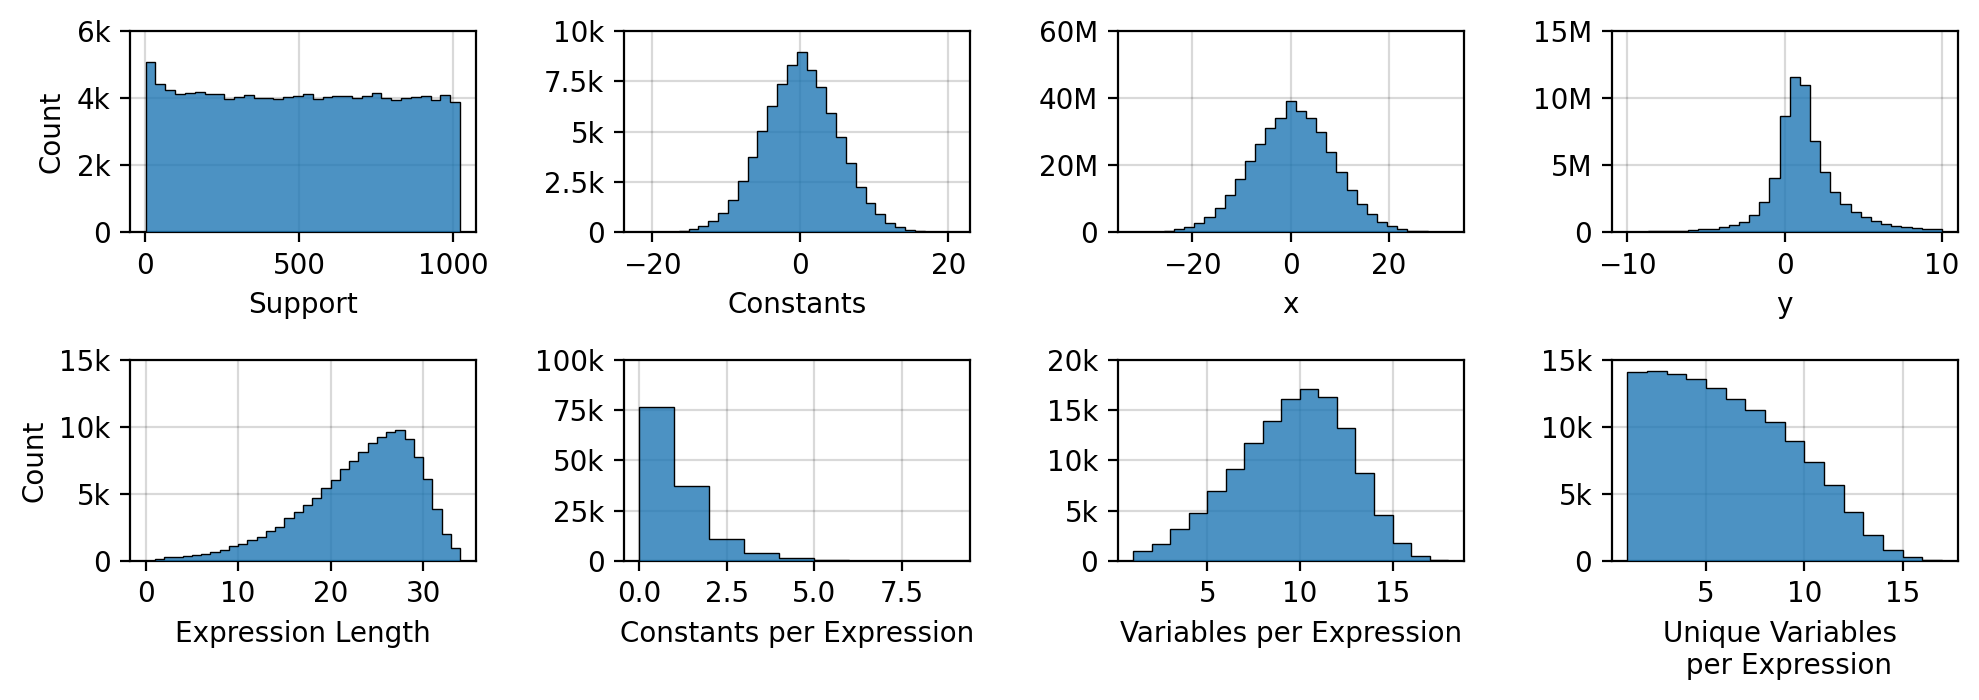

In [56]:
histogram_keys = ['n_support', 'all_constants', 'all_x', 'all_y', 'lengths', 'n_constants', 'n_variables', 'n_unique_variables']
titles = ['Support', 'Constants', 'x', 'y', 'Expression Length', 'Constants per Expression', 'Variables per Expression', 'Unique Variables \n per Expression']
bins_list = [32, 32, np.linspace(-32, 32, 32), np.linspace(-10, 10, 32), np.arange(0, data['lengths'].max()), np.unique(data['n_constants']), np.unique(data['n_variables']), np.unique(data['n_unique_variables'])]

COLS = min(4, len(histogram_keys))
ROWS = np.ceil(len(histogram_keys) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 2.5, ROWS * 1.8), dpi=200)

for i, (ax, k, bins, title) in enumerate(zip(axes.flatten(), histogram_keys, bins_list, tqdm(titles))):

    d = data[k]
    print(f'{len(d):,} samples for {k}')
    if k == 'all_y':
        d = np.log10(np.abs(d[d != 0]))

    ax.hist(d, bins=bins, zorder=4, alpha=0.8, rasterized=True)
    ax.hist(d, bins=bins, zorder=6, histtype='step', edgecolor='k', linewidth=0.5, rasterized=True)
    ax.set_xlabel(title)
    if i % COLS == 0:
        ax.set_ylabel('Count')
    ax.grid(alpha=0.15, color='k')
    # ax.set_xticks(np.arange(0, 20, 5));

    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels([format_int(y) for y in ax.get_yticks()])

for ax in axes.flatten()[len(histogram_keys):]:
    ax.set_axis_off()

fig.tight_layout(w_pad=2)

plt.savefig(get_path('results', 'data_analysis', create=True, filename='data_histograms.svg'), bbox_inches='tight')

 75%|███████▌  | 3/4 [00:00<00:00, 66.99it/s]


131,072 samples for lengths
131,072 samples for n_constants
131,072 samples for n_variables
131,072 samples for n_unique_variables


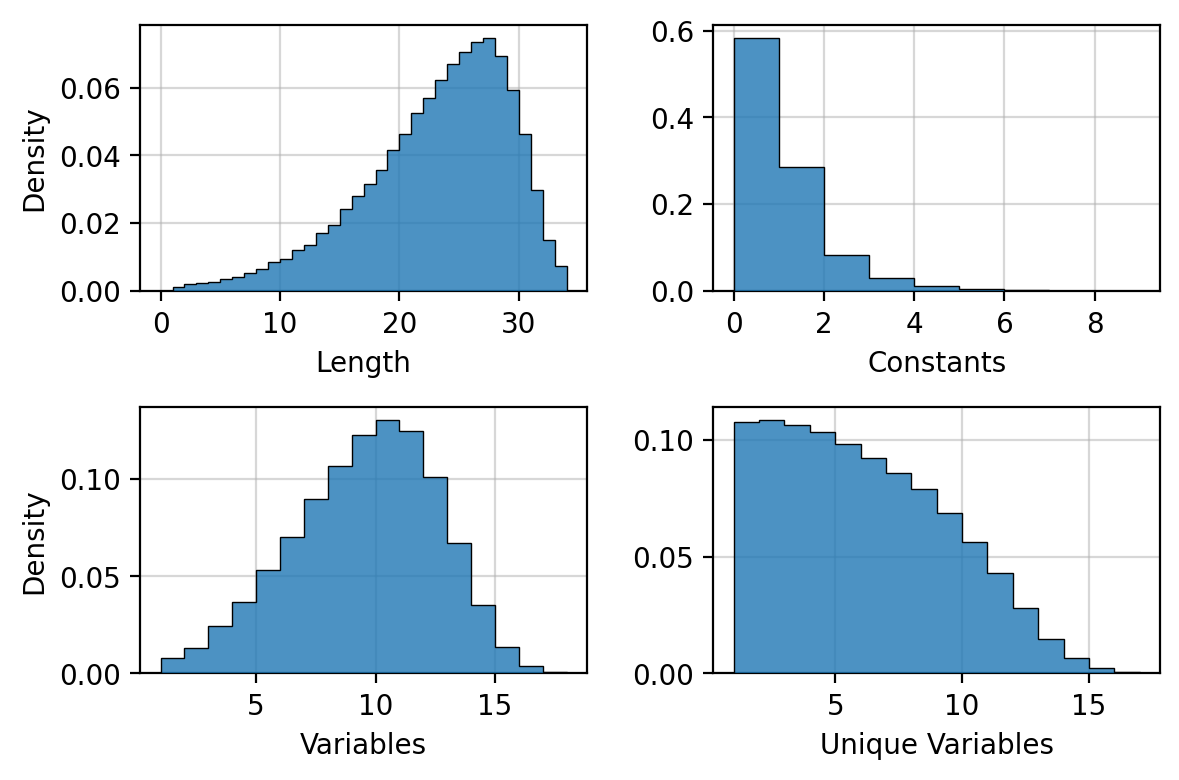

In [62]:
histogram_keys = ['lengths', 'n_constants', 'n_variables', 'n_unique_variables']
titles = ['Length', 'Constants', 'Variables', 'Unique Variables']
bins_list = [np.arange(0, data['lengths'].max()), np.unique(data['n_constants']), np.unique(data['n_variables']), np.unique(data['n_unique_variables'])]

COLS = min(2, len(histogram_keys))
ROWS = np.ceil(len(histogram_keys) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 2), dpi=200)

for i, (ax, k, bins, title) in enumerate(zip(axes.flatten(), histogram_keys, bins_list, tqdm(titles))):

    d = data[k]
    print(f'{len(d):,} samples for {k}')
    if k == 'all_y':
        d = np.log10(np.abs(d[d != 0]))

    ax.hist(d, bins=bins, zorder=4, alpha=0.8, rasterized=True, density=True)
    ax.hist(d, bins=bins, zorder=6, histtype='step', edgecolor='k', linewidth=0.5, rasterized=True, density=True)
    ax.set_xlabel(title)
    if i % COLS == 0:
        ax.set_ylabel('Density')
    ax.grid(alpha=0.5)

for ax in axes.flatten()[len(histogram_keys):]:
    ax.set_axis_off()

fig.tight_layout(w_pad=1)

plt.savefig(get_path('results', 'data_analysis', create=True, filename='data_histograms.svg'), bbox_inches='tight')

131,072 samples for n_constants
131,072 samples for n_unique_variables
131,072 samples for n_variables
131,072 samples for lengths


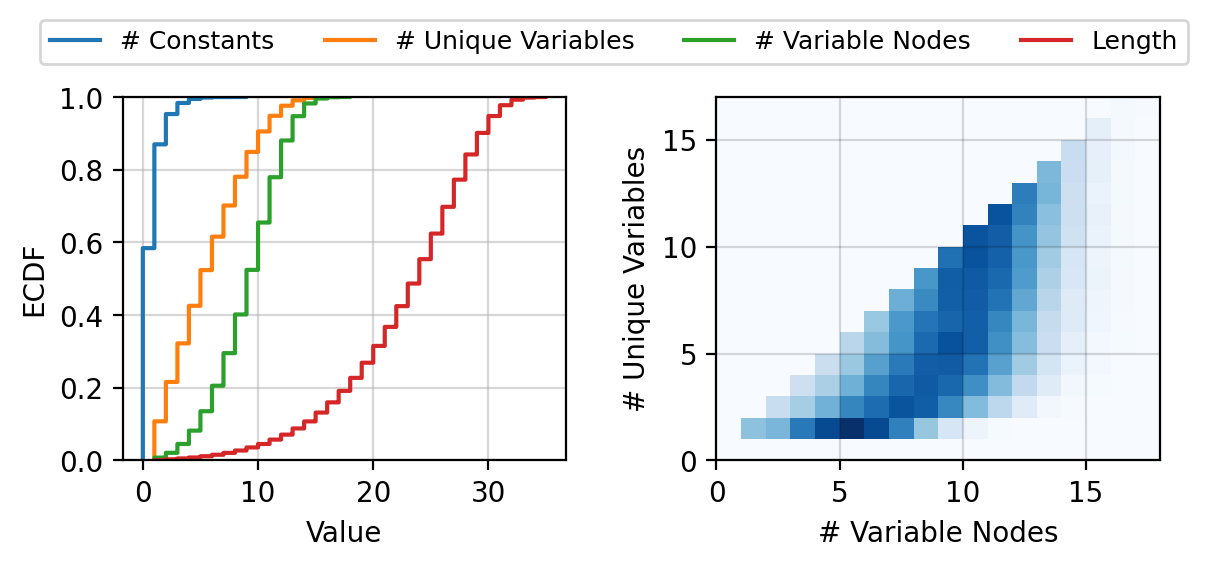

In [128]:
histogram_keys = ['n_constants', 'n_unique_variables', 'n_variables', 'lengths']
titles = ['# Constants', '# Unique Variables', '# Variable Nodes', 'Length']

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=200)
axes: list[plt.Axes]

for k, title in zip(histogram_keys, titles):
    d = np.sort(data[k])
    print(f'{len(d):,} samples for {k}')
    ecdf = np.arange(1, len(d) + 1) / len(d)
    axes[0].step(d, ecdf, where='post', label=title)

axes[0].set_xlabel('Value')
axes[0].set_ylabel('ECDF')
axes[0].set_ylim(0, 1)
axes[0].grid(alpha=0.5)

# Put a shared legend above both plots, horizontal layout
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.52, 0.95), fontsize=9)

axes[1].hist2d(data['n_variables'], data['n_unique_variables'], bins=(np.arange(0, data['n_variables'].max()+1), np.arange(0, data['n_unique_variables'].max()+1)), cmap='Blues', rasterized=True)
axes[1].set_xlabel('# Variable Nodes')
axes[1].set_ylabel('# Unique Variables')
# plt.colorbar(label='Count', ax=axes[1])
axes[1].grid(alpha=0.15, color='k')

fig.tight_layout()
fig.subplots_adjust(top=0.8)

plt.savefig(get_path('results', 'data_analysis', create=True, filename='additional_data_histograms.svg'), bbox_inches='tight')


In [90]:
data['skeleton'][6]

['/',
 '*',
 'x10',
 '+',
 'x3',
 'x8',
 '+',
 'x6',
 'inv',
 '*',
 'x17',
 '*',
 '/',
 'x11',
 'sinh',
 '-',
 'x7',
 'cosh',
 '-',
 '/',
 'div3',
 '+',
 'x14',
 'x4',
 '+',
 'x13',
 'x9',
 'x12',
 'x1']

In [91]:
operator_counts = {op: 0 for op in dataset.skeleton_pool.simplipy_engine.operator_arity.keys()}
for skeleton in data['skeleton']:
    for token in skeleton:
        if token in dataset.skeleton_pool.simplipy_engine.operator_arity.keys():
            operator_counts[token] += 1

In [92]:
variable_counts = {v: 0 for v in dataset.skeleton_pool.variables}
for skeleton in data['skeleton']:
    for token in skeleton:
        if token in dataset.skeleton_pool.variables:
            variable_counts[token] += 1
variable_counts

{'x1': 69867,
 'x2': 69792,
 'x3': 69490,
 'x4': 69361,
 'x5': 69699,
 'x6': 69831,
 'x7': 69875,
 'x8': 69346,
 'x9': 69726,
 'x10': 69855,
 'x11': 70343,
 'x12': 69872,
 'x13': 69460,
 'x14': 69530,
 'x15': 69635,
 'x16': 69998,
 'x17': 69556}

In [93]:
operators_total = sum(operator_counts.values())
normalized_operator_counts = {op: count / operators_total for op, count in operator_counts.items()}
normalized_operator_counts_prior = np.array(list(dataset.skeleton_pool.operator_weights.values())) / sum(dataset.skeleton_pool.operator_weights.values())

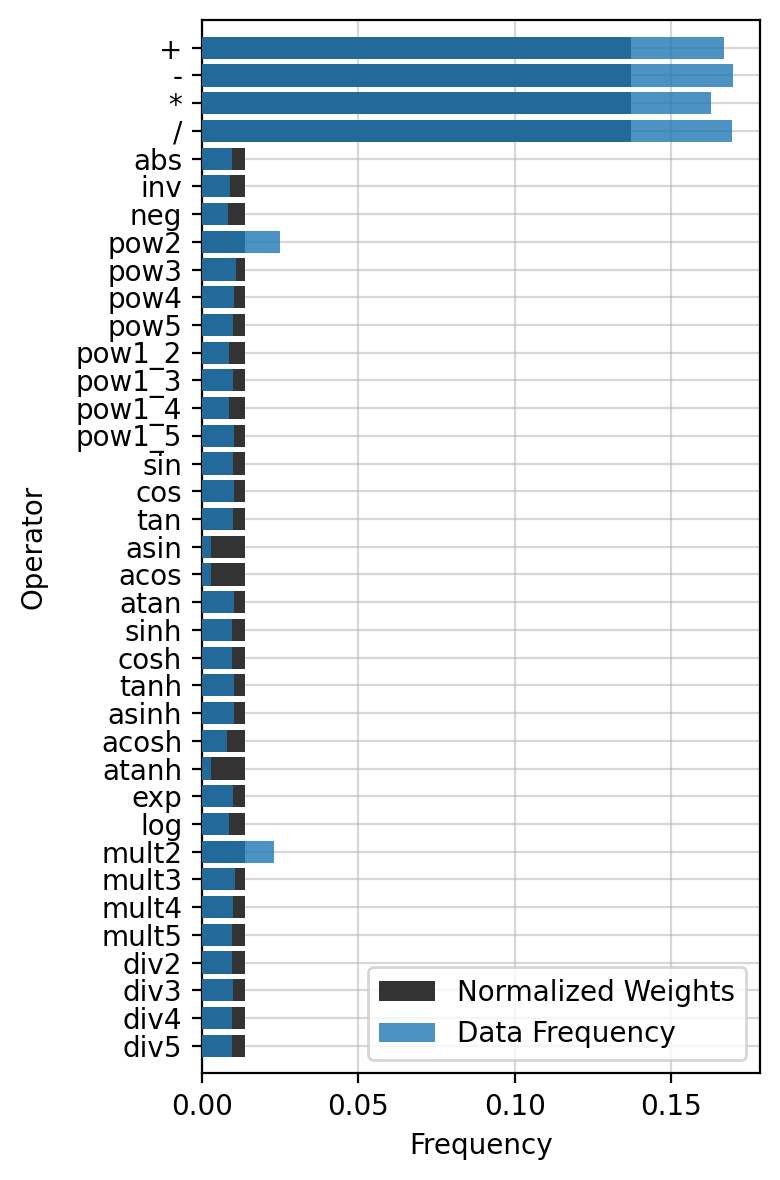

In [118]:
fig, ax = plt.subplots(figsize=(4, 6), dpi=200)

ax.barh(dataset.skeleton_pool.operator_weights.keys(), normalized_operator_counts_prior, zorder=4, color='#333333', label='Normalized Weights', rasterized=True)
ax.barh(dataset.skeleton_pool.operator_weights.keys(), [normalized_operator_counts[op] for op in dataset.skeleton_pool.operator_weights.keys()], zorder=6, alpha=0.8, label='Data Frequency', rasterized=True)

ax.set_ylim(-1, len(dataset.skeleton_pool.operator_weights))

ax.invert_yaxis()

ax.set_xlabel('Frequency')
ax.set_ylabel('Operator', labelpad=10)
ax.grid(alpha=0.5, zorder=1)

ax.legend()

fig.tight_layout()

plt.savefig(get_path('results', 'data_analysis', create=True, filename='train_operator_frequencies.svg'), bbox_inches='tight')

In [95]:
from collections import Counter

In [96]:
# Most common expressions
counter = Counter([tuple(s) for s in data['skeleton']])

In [97]:
# Note: various permutations of the same expressions may not be present due to filtering of held-out expressions
for expression, count in counter.most_common(32):
    print(f'{count:>3}: {(expression)}')

 19: ('x6',)
 14: ('x3',)
 14: ('x2',)
 13: ('x15',)
 12: ('x10',)
 11: ('x4',)
 11: ('x16',)
 11: ('x8',)
 10: ('x13',)
 10: ('x9',)
  9: ('x17',)
  7: ('neg', 'x8')
  7: ('x12',)
  7: ('neg', 'x16')
  7: ('/', 'x15', '<constant>')
  7: ('neg', 'x6')
  6: ('/', 'x13', '<constant>')
  6: ('mult2', 'x10')
  5: ('neg', 'x17')
  5: ('neg', 'x10')
  5: ('neg', 'x2')
  4: ('neg', 'x15')
  4: ('/', 'x16', '<constant>')
  4: ('neg', 'x9')
  4: ('pow2', 'x5')
  4: ('neg', 'x4')
  4: ('/', 'x6', '<constant>')
  3: ('mult2', 'x5')
  3: ('pow2', 'x2')
  3: ('neg', 'pow2', 'x12')
  3: ('mult2', 'x15')
  3: ('pow2', 'x10')


In [98]:
one_dimensional_x = np.array([np.array(x_tensor) for x_tensor, n_unique_variables in zip(data['x_tensors'], data['n_unique_variables']) if n_unique_variables == 1])
one_dimensional_x = np.array([x[:, np.where((~(x == 0).all(axis=0)))[0][0]].flatten() for x in one_dimensional_x])

one_dimensional_y = np.array([np.array(y_tensor).flatten() for y_tensor, n_unique_variables in zip(data['y_tensors'], data['n_unique_variables']) if n_unique_variables == 1])

print(one_dimensional_x.shape, one_dimensional_y.shape)

one_dimensional_x = np.concatenate(one_dimensional_x)
one_dimensional_y = np.concatenate(one_dimensional_y)

print(one_dimensional_x.shape, one_dimensional_y.shape)

/tmp/ipykernel_18656/985064896.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  one_dimensional_x = np.array([np.array(x_tensor) for x_tensor, n_unique_variables in zip(data['x_tensors'], data['n_unique_variables']) if n_unique_variables == 1])
/tmp/ipykernel_18656/985064896.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  one_dimensional_y = np.array([np.array(y_tensor).flatten() for y_tensor, n_unique_variables in zip(data['y_tensors'], data['n_unique_variables']) i

(14110, 1024) (14110, 1024)
(14448640,) (14448640,)


In [99]:
from matplotlib.colors import LogNorm

In [100]:
tuple(np.array(plt.get_cmap('viridis')(0))[:3] * 0.5) + (1.0,)

(np.float64(0.133502), np.float64(0.002437), np.float64(0.1647075), 1.0)

In [101]:
one_dimensional_x.shape,one_dimensional_y.shape

((14448640,), (14448640,))

/tmp/ipykernel_18656/2852008035.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


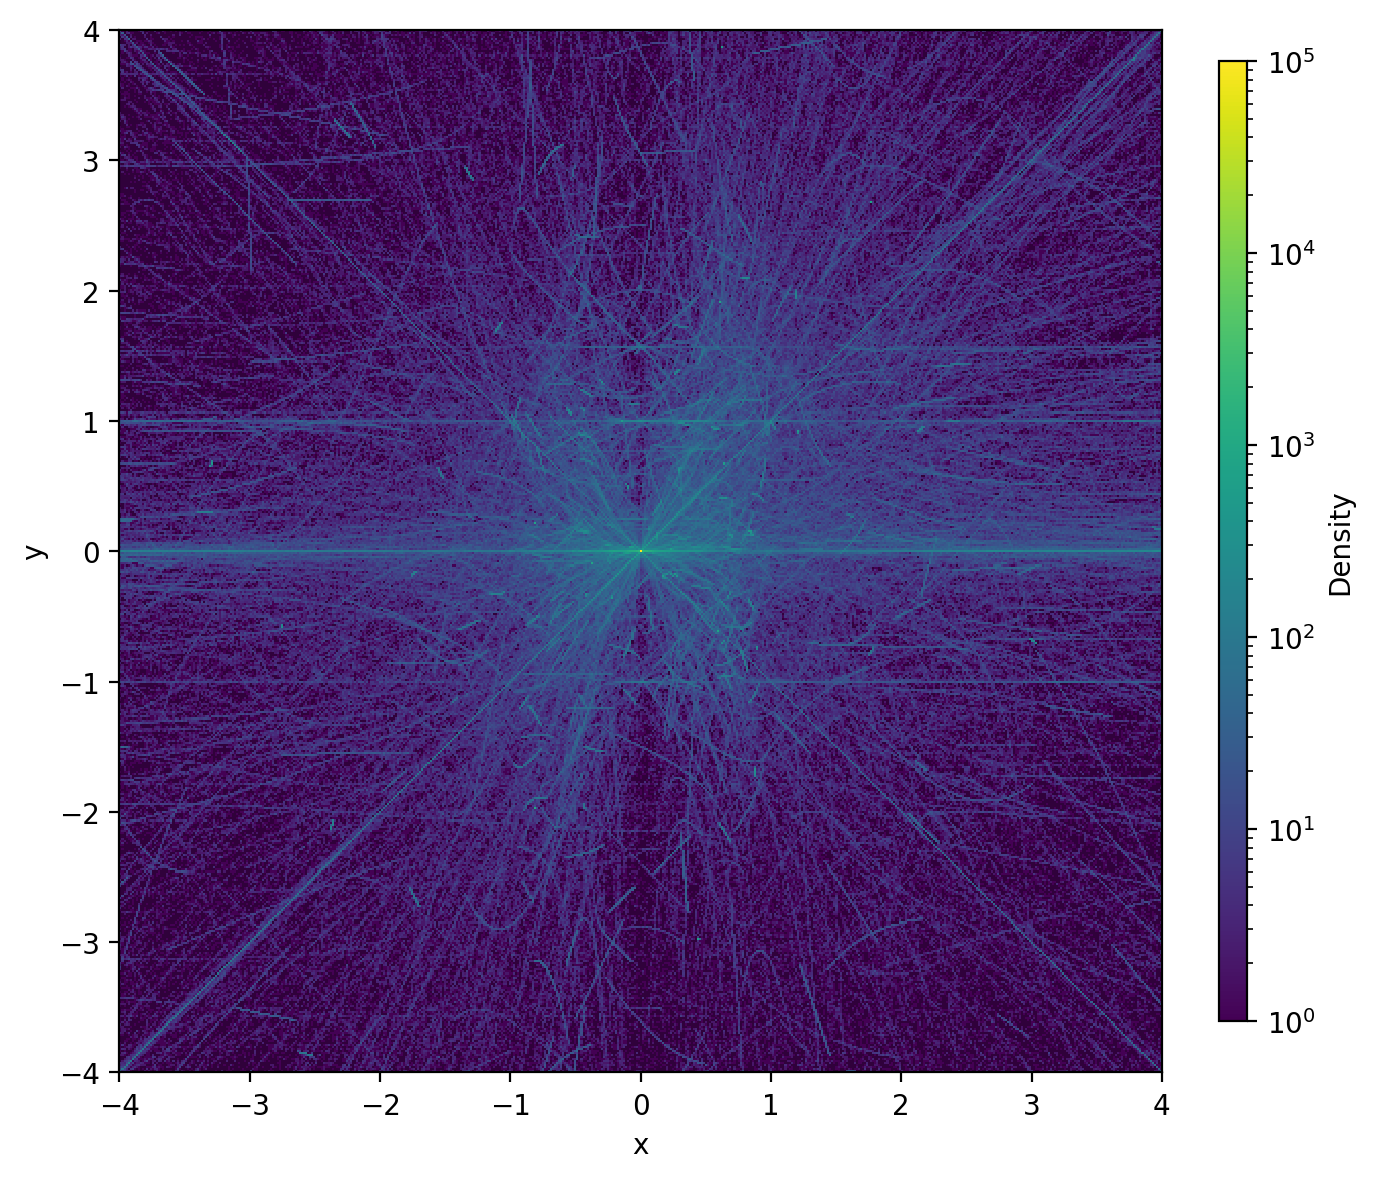

In [117]:
fig, ax = plt.subplots(figsize=(7, 6), dpi=200)

# Change the fontsize
plt.rcParams.update({'font.size': 10})

res = 256
lim = 4
img = ax.hist2d(one_dimensional_x, one_dimensional_y, bins=(np.linspace(-lim, lim, res*2), np.linspace(-lim, lim, res*2)), norm=LogNorm(vmin=1, vmax=1e5), rasterized=True);
ax.set_facecolor(tuple(np.array(plt.get_cmap('viridis')(0))[:3] * 0.7) + (1,))

ax.set_aspect('equal')

ax.set_xlabel('x', fontsize=10)
ax.set_ylabel('y', fontsize=10)

# Colorbar
cbar_ax = fig.add_axes([0.92, 0.14, 0.02, 0.80])
fig.colorbar(img[3], cax=cbar_ax, label='Density')

fig.tight_layout()

plt.savefig(get_path('results', 'data_analysis', create=True, filename='1d_train_superimposed.svg'), bbox_inches='tight')